# Analysis of early termination data

Data produced from the `_run_simulations` method in [`PoincareEnsemble.ipynb`](PoincareEnsemble.ipynb)

- We are numerically integrating double pendulum simulations with release angles $\theta_1, \theta_2 \in [0, \pi]$

- A termination event for the integration is defined as either of the angles reaching $10 * \tau$ (10 complete circles)

The initial conditions are selected using a biased Monte Carlo ensemble method. At the moment we generate $10^3$ initial conditions but will push to $10^4$ and beyond after runtime optimisations. Roughly 50% of simulations terminated early, of these, roughly 25% terminated before 1 minute (I can live with termination after 1 minute)

##### The aim of this analysis is to write filters to excluded certain angle combinations to optimise early termination (I can live with 10% terminating before 1 minute)

I need to find patterns in the below numerical data to exclude certain $\theta_1, \theta_2$ combinations in my biased sampling

In [2]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
df = pd.read_csv('raw_termination_data.csv')
df.head()

,initial_conditions,termination_time,termination_reason
0,"(np.float64(0.5235987755982988), np.float64(2....",52.517603,Large deviation
1,"(np.float64(0.5235987755982988), np.float64(2....",103.825059,Large deviation
2,"(np.float64(0.7853981633974483), np.float64(2....",63.842269,Large deviation
3,"(np.float64(0.7853981633974483), np.float64(2....",99.137393,Large deviation
4,"(np.float64(1.0471975511965976), np.float64(2....",58.162634,Large deviation


In [4]:
unique_reasons = df['termination_reason'].unique()
print(unique_reasons)

['Large deviation']


In [5]:
def extract_floats(condition):
    # extract values wrapped in np.float64
    match = re.findall(r'np\.float64\((.*?)\)', condition)
    if match:
        return tuple(map(float, match))
    else:
        # If no np.float64 wrapping, split the tuple and convert to floats
        stripped = condition.strip("()")
        parts = [x.strip() for x in stripped.split(',')]
        return float(parts[0]), float(parts[1])

# Apply the function and split the result into two new columns
df[['theta1_radians', 'theta2_radians']] = df['initial_conditions'].apply(lambda x: extract_floats(x)).apply(pd.Series)

In [6]:
# Convert radians to degrees and round to 2 decimal places
df['theta1_degrees'] = df['theta1_radians'].apply(lambda x: round(np.degrees(x), 2))
df['theta2_degrees'] = df['theta2_radians'].apply(lambda x: round(np.degrees(x), 2))

df.drop(columns=['initial_conditions', 'termination_reason'], inplace=True)
df = df.sort_values(by='termination_time')

In [7]:
df.head(10)

,termination_time,theta1_radians,theta2_radians,theta1_degrees,theta2_degrees
313,17.117774,1.90724,1.71750,109.28,98.41
195,17.945598,0.69495,3.10285,39.82,177.78
116,18.728573,2.84050,1.09408,162.75,62.69
308,18.902102,2.58432,1.33121,148.07,76.27
262,21.282789,2.06939,1.56513,118.57,89.68
80,21.586246,2.06935,0.51187,118.57,29.33
356,21.881401,2.91566,0.70565,167.06,40.43
83,21.890259,2.65425,0.07311,152.08,4.19
449,21.913907,2.57987,0.00492,147.82,0.28
94,22.008398,1.33273,2.84740,76.36,163.14


In [8]:
df.describe()

,termination_time,theta1_radians,theta2_radians,theta1_degrees,theta2_degrees
count,472.000000,472.000000,472.000000,472.000000,472.000000
mean,62.959494,1.879248,1.529168,107.672903,87.614788
std,24.784004,0.645573,0.912754,36.988593,52.296928
min,17.117774,0.057780,0.004920,3.310000,0.280000
25%,44.871677,1.474538,0.718228,84.485000,41.150000
50%,59.215271,1.929610,1.514740,110.555000,86.785000
75%,78.878436,2.335125,2.343465,133.790000,134.270000
max,119.167895,3.139750,3.132560,179.890000,179.480000


In [ ]:
# Output the DataFrame to a CSV file
df.to_csv("clean_termination_data.csv", index=False)

----
&nbsp;
#### Filtering for termination time < 60 seconds

In [9]:
filtered_df = df[df['termination_time'] < 60]
filtered_df = filtered_df[['termination_time', 'theta1_degrees', 'theta2_degrees']]
print(f"Dataframe shape: {filtered_df.shape}")

Dataframe shape: (241, 3)


In [10]:
correlation_matrix = filtered_df.corr()
correlation_matrix

,termination_time,theta1_degrees,theta2_degrees
termination_time,1.000000,-0.150300,0.194371
theta1_degrees,-0.150300,1.000000,-0.774614
theta2_degrees,0.194371,-0.774614,1.000000


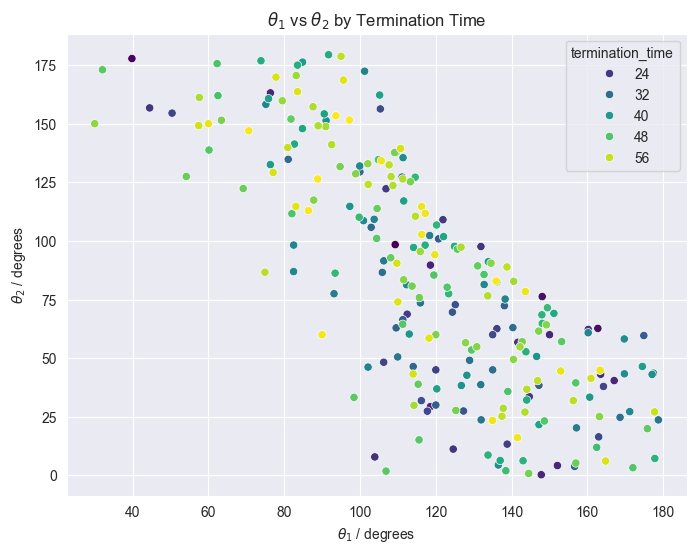

In [11]:
# Scatter plot of theta1 vs theta2 colored by termination_time
plt.figure(figsize=(8, 6))
sns.scatterplot(x='theta1_degrees', y='theta2_degrees', hue='termination_time', 
                palette='viridis', data=filtered_df)
plt.title(r'$\theta_1$ vs $\theta_2$ by Termination Time')
plt.xlabel(r'$\theta_1$ / degrees')
plt.ylabel(r'$\theta_2$ / degrees')
plt.show()

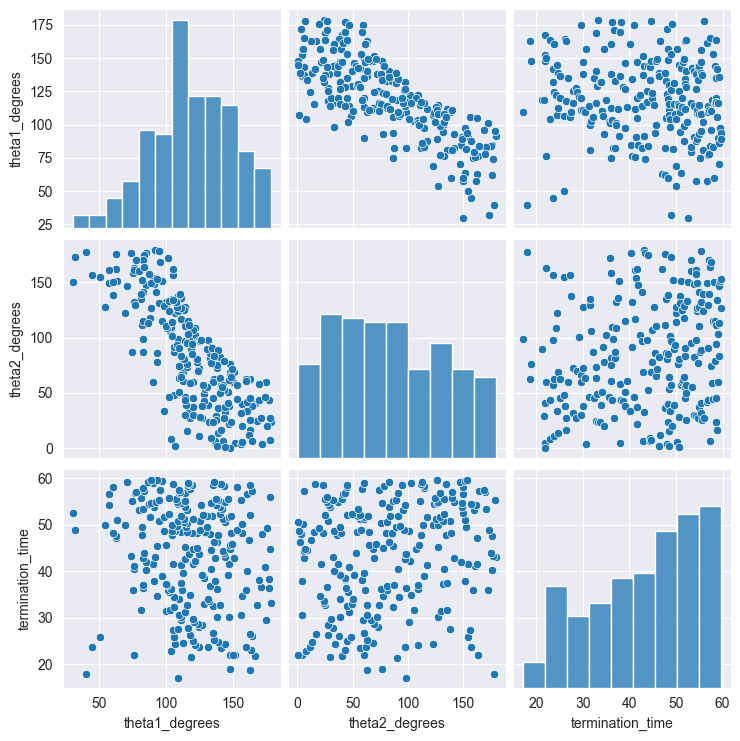

In [16]:
# Pair plot of theta1, theta2, and termination_time
sns.pairplot(filtered_df[['theta1_degrees', 'theta2_degrees', 'termination_time']])
plt.show()

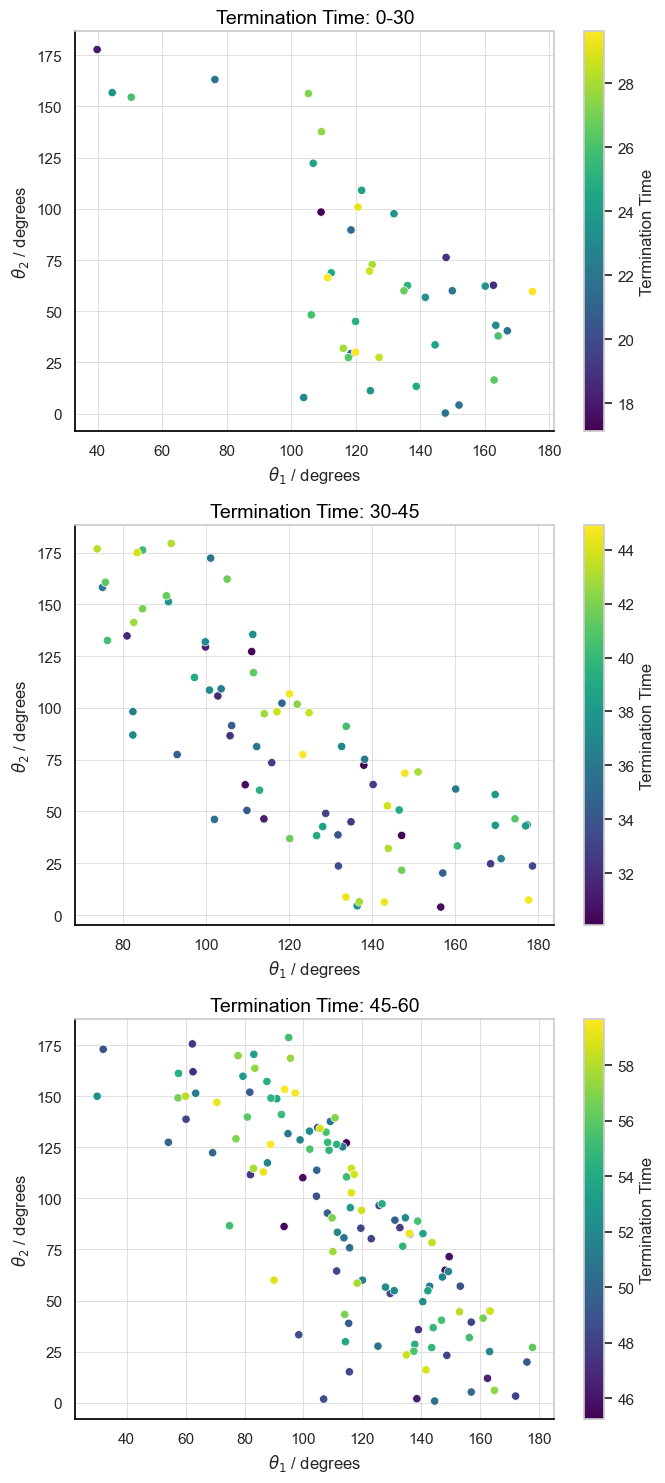

In [23]:
custom_bins = [0, 30, 45, 60]
bin_labels = ['0-30', '30-45', '45-60']

filtered_df['termination_bin'] = pd.cut(filtered_df['termination_time'], bins=custom_bins, labels=bin_labels, include_lowest=True)
fig, axes = plt.subplots(3, 1, figsize=(7, 15))  # 1x3 grid for 3 bins

# Iterate through each bin and create a scatter plot in its corresponding subplot
for i, (bin_name, group) in enumerate(filtered_df.groupby('termination_bin', observed=True)):
    ax = axes[i] 
    norm = plt.Normalize(group['termination_time'].min(), group['termination_time'].max())
    sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
    sm.set_array([])  # Necessary for ScalarMappable
    sns.scatterplot(data=group, x='theta1_degrees', y='theta2_degrees', 
                    hue='termination_time', ax=ax, palette='viridis', legend=False)
    
    # Set the title and labels
    ax.set_title(f'Termination Time: {bin_name}', fontsize=14, color='black')
    ax.set_xlabel(r'$\theta_1$ / degrees')
    ax.set_ylabel(r'$\theta_2$ / degrees')
    
    # Customize the grid and axes colors
    ax.set_facecolor('white') 
    ax.grid(True, which='major', linestyle='-', linewidth='0.5', color='lightgrey')
    ax.spines['left'].set_color('black')
    ax.spines['bottom'].set_color('black')
    
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Termination Time')

plt.tight_layout()
plt.show()

----
&nbsp;
## This is what I have so far... I'm in the long grass and don't know how to turn this analysis into actionable insights